In [1]:
# # Flow equations library: Laplace equation
# This notebook demonstrates how to use the Flow equations library.
# We will solve the Laplace equation:
# $$
# \frac{d^2u}{dx^2}+\frac{d^2u}{dy^2}=0,\\
# u(0,\, y)=\sin(\pi y),\\
# u(x,\, 0)=0,\\
# u(L,\, y)=0,\\
# u(x,\, H)=0,
# $$
# First, we will build the problem using Flow's SymPy interface and then skip it altogether
# by using the same equation available in `flow.prefabs`, together with other ODEs/PDEs.

from __future__ import annotations

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import sympy
import torch
from pathlib import Path
from sympy import Eq, Function, symbols

from flow import PINN
from flow.data import dictdataloader
from flow.geometry import Line2D, Point2D, Rectangle
from flow.models import MLP
from flow.prefabs import LaplaceLeft as Laplace
from flow.prefabs.visualise import contourf
from flow.terms import EqTerm
from flow.train import TrainConfig, train
from flow.utils.random import set_all_seeds




# With prefabs
# Equation definition
# We can also optionally specify whether we want supervised data and if we want them perturbed
# with a Gaussian noise amplitude.
# Additionally, one can also specify the bounds of the expected solution,
# thus helping us scale the output to match that range.
# Let us say, we expect the solution to be bounded between $(0, 1)$,
# we can specify that using the `solution_bounds` argument.
data = False
if data:
    de = Laplace(n_data_samples=500, pert_data=0.1, solution_bounds=(0, 1))
    
else:
    de = Laplace()


# `de` can be printed out in a human readable and loggable form
print(de)



# Flow problem definition
problem = de.flow_problem

# Data loader
batch_sizes = {
    "pde": 100,
    "left": 20,
    "bottom": 20,
    "right": 20,
    "top": 20,
}

if data:
    batch_sizes.update({"data": 5})

dataloader = de.ddl(batch_sizes, geom_sampling="random_points")


# PINN model and training
# Note that in the UFA definition below, as we specify the `act_fn` to be `tanh` function,
# the output falls in the range $(-1, 1)$.
# However, since we expect the solution to be bounded by $(0, 1)$,
# we can further linearly transoform the output to better match the given range.
# This would imply, that we should scale the output by 0.5 and shift it by 0.5.
mlp_layers = (2, 20, 20, 1)
lr = 1e-2

output_shifting = 0.5 * (de.solution_bounds[1] + de.solution_bounds[0])
output_scaling = (de.solution_bounds[1] - de.solution_bounds[0]) / (1.0 - (-1.0))




LaplaceLeft(n_data_samples=0, pert_data=0.0, pin_memory=False, _default_batch_sizes={'pde': 100, 'left': 20, 'bottom': 20, 'right': 20, 'top': 20, 'data': 0}, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, solution_bounds=(0.0, 1.0), u0=<function LaplaceLeft.<lambda> at 0x31dad8ee0>, u0_args={}, relative_tolerance_on_right_bc=0.01)


In [2]:

from qadence.draw import html_string # markdown-exec: hide

from qadence import BasisSet, chain, create_fm_blocks, FeatureMapConfig, ReuploadScaling

fm_config = FeatureMapConfig(
    num_features=2,
    inputs = ["x", "y"],
    basis_set=BasisSet.CHEBYSHEV,
    reupload_scaling=ReuploadScaling.TOWER,
    feature_range={
        "x": (-1.0, 1.0),
        "y": (0.0, 1.0),
    },
)

fm_blocks = create_fm_blocks(register=4, config=fm_config)
feature_map = chain(*fm_blocks)

from qadence import AnsatzConfig, AnsatzType, create_ansatz, Strategy

ansatz_config = AnsatzConfig(
    depth=1,
    ansatz_type=AnsatzType.HEA,
    ansatz_strategy=Strategy.DIGITAL,
)

ansatz = create_ansatz(register=4, config=ansatz_config)





In [ ]:
from qadence import ObservableConfig, Z, VariationalParameter,I,X,Interaction
from qadence.ml_tools.constructors import create_observable
def custom_int(i: int, j: int):
    return X(i) + Z(i)+ Z(i)@Z(j)


observable_config = ObservableConfig(
    interaction=custom_int,
    shift=0.5,
)

observable = create_observable(register=4, config=observable_config)

print(observable) # markdown-exec: hide


TypeError: Please use a custom interaction function signed with two integer parameters.

In [4]:
from qadence import BackendName, DiffMode, QNN

ufa = QNN.from_configs(
    register=4,
    obs_config=observable_config,
    fm_config=fm_config,
    ansatz_config=ansatz_config,
    backend=BackendName.PYQTORCH,
    diff_mode=DiffMode.AD,
)

from torchinfo import summary
summary(ufa)

Layer (type:depth-idx)                                                      Param #
QNN                                                                         --
├─ConvertedCircuit: 1-1                                                     --
│    └─QuantumCircuit: 2-1                                                  --
│    │    └─ModuleList: 3-1                                                 --
├─ParameterDict: 1-2                                                        14
Total params: 14
Trainable params: 12
Non-trainable params: 2

In [5]:
for name, param in ufa.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Shape: {param.shape}")

print(ufa.named_parameters())
print(len(list(ufa.named_parameters())))


Parameter: _params.theta_0, Shape: torch.Size([1])
Parameter: _params.theta_1, Shape: torch.Size([1])
Parameter: _params.theta_10, Shape: torch.Size([1])
Parameter: _params.theta_11, Shape: torch.Size([1])
Parameter: _params.theta_2, Shape: torch.Size([1])
Parameter: _params.theta_3, Shape: torch.Size([1])
Parameter: _params.theta_4, Shape: torch.Size([1])
Parameter: _params.theta_5, Shape: torch.Size([1])
Parameter: _params.theta_6, Shape: torch.Size([1])
Parameter: _params.theta_7, Shape: torch.Size([1])
Parameter: _params.theta_8, Shape: torch.Size([1])
Parameter: _params.theta_9, Shape: torch.Size([1])
<generator object Module.named_parameters at 0x31db72500>
14


In [6]:
optimizer = torch.optim.Adam(ufa.parameters(), lr, foreach=False)

model = PINN(problem, ufa)


# Training
max_iter = 10
config = TrainConfig(
    max_iter, print_every=200, root_folder=output_root_folder, create_subfolder_per_run=True
)

train(model, dataloader, optimizer, config)



NameError: name 'output_root_folder' is not defined

Text(0, 0.5, 'y')

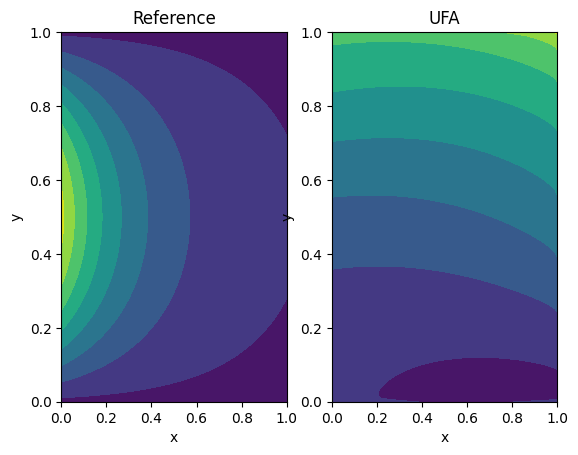

In [55]:
# Contour plot
# The benchmark solution is already included in `Laplace` and can be easily plotted
fig, axs = plt.subplots(1, 2)
contourf(axs[0], de, num_gridpoints_x1=100, num_gridpoints_x2=100)

# If we specify a UFA, we can also plot its solution.
contourf(axs[1], de, num_gridpoints_x1=100, num_gridpoints_x2=100, ufa=ufa)

# decorating axes
axs[0].set_title("Reference")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].set_title("UFA")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

